In [5]:
import warnings
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
import sys
import scienceplots
sys.path.append("../FinRL-Library")
plt.style.use('science')

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - (time_window) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            account_memory = df_account_value
            actions_memory = df_actions

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
def mvo_data(data, INDICATORS, TEST_START_DATE, TEST_END_DATE):
    final_result = []
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df
def mvo(data, solver='OSQP',window=1, rf=0.02, pct=0.001,objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window":window

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective,cost=pct)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result
    

# DOW

In [6]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow[df_dow["date"] > TRAIN_START_DATE])
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 27, State Space: 82


In [246]:
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0.001,rf=0)
min_variance_portfolio = mvo(covs,pct=0.001)

begin_total_asset:50000
end_total_asset:69491.79156540424
Sharpe:  1.388474086480592
Test Finished!
episode_return 1.389835831308085
begin_total_asset:50000
end_total_asset:61659.30449552075
Sharpe:  1.127712929790266
Test Finished!
episode_return 1.233186089910415


In [247]:
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0,rf=0)
min_variance_portfolio = mvo(covs,pct=0)

begin_total_asset:50000
end_total_asset:58803.278034657356
Sharpe:  0.7405653557655673
Test Finished!
episode_return 1.1760655606931472
begin_total_asset:50000
end_total_asset:63914.3221311137
Sharpe:  1.373618217323887
Test Finished!
episode_return 1.278286442622274


In [3]:
def train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=False,use_dsr=False,use_sortino=False,model_name='a2c'
                ,iterations = 100_000,save=True,load=False,tag='tag',features=["close","log_return"],t=5,args=None,indicators =None,starting_capital = 50_000):

    env_kwargs = {
        "initial_amount": starting_capital, 
        "normalize_df":None,
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
        'use_differentail_sharpe_ratio':use_dsr,
        
    }
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    env_kwargs = {
        "initial_amount": starting_capital, 
        "normalize_df":None,
        'comission_fee_pct':transaction_fee,
        "features" :features,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
        'use_differentail_sharpe_ratio':use_dsr,
    }

    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  verbose=0,
                                model_kwargs = args)

    
    if not load:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name,
                                    total_timesteps=iterations)
    else:
        print('loading model')
        model = model_agent.load('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag,env =train_environment)
    if save and not load:
        model.save('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results

In [109]:
iterations = 80_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=True)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True)


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Episode:1
Initial portfolio value:50000
Final portfolio value: 508907.65625
Final accumulative portfolio value: 10.178153125
Episode:2
Initial portfolio value:50000
Final portfolio value: 622523.8125
Final accumulative portfolio value: 12.45047625
Episode:3
Initial portfolio value:50000
Final portfolio value: 403252.21875
Final accumulative portfolio value: 8.065044375
Episode:4
Initial portfolio value:50000
Final portfolio value: 422702.96875
Final accumulative portfolio value: 8.454059375
Episode:5
Initial portfolio value:50000
Final portfolio value: 367146.8125
Final accumulative portfolio value: 7.34293625
Episode:6
Initial portfolio value:50000
Final portfolio value: 355910.9375
Final accumulative portfolio value: 7.11821875
Episode:7
Initial portfolio value:50000
Final portfolio value: 329024.4375
Final accumulative portfolio value: 6.58048875
Episode:8
Initial portfolio value:50000
Final portfolio value: 333452.25

In [116]:
iterations = 80_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',use_sharpe=True,tag='sharpe_1')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,use_sharpe=True,tag='sharpe_1')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,use_sharpe=True,tag='sharpe_1')


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Episode:1
Initial portfolio value:50000
Final portfolio value: 564571.6875
Final accumulative portfolio value: 11.29143375
Episode:2
Initial portfolio value:50000
Final portfolio value: 598705.0625
Final accumulative portfolio value: 11.97410125
Episode:3
Initial portfolio value:50000
Final portfolio value: 573224.875
Final accumulative portfolio value: 11.4644975
Episode:4
Initial portfolio value:50000
Final portfolio value: 475541.09375
Final accumulative portfolio value: 9.510821875
Episode:5
Initial portfolio value:50000
Final portfolio value: 426788.03125
Final accumulative portfolio value: 8.535760625
Episode:6
Initial portfolio value:50000
Final portfolio value: 423339.0625
Final accumulative portfolio value: 8.46678125
Episode:7
Initial portfolio value:50000
Final portfolio value: 485946.09375
Final accumulative portfolio value: 9.718921875
Episode:8
Initial portfolio value:50000
Final portfolio value: 475930.593

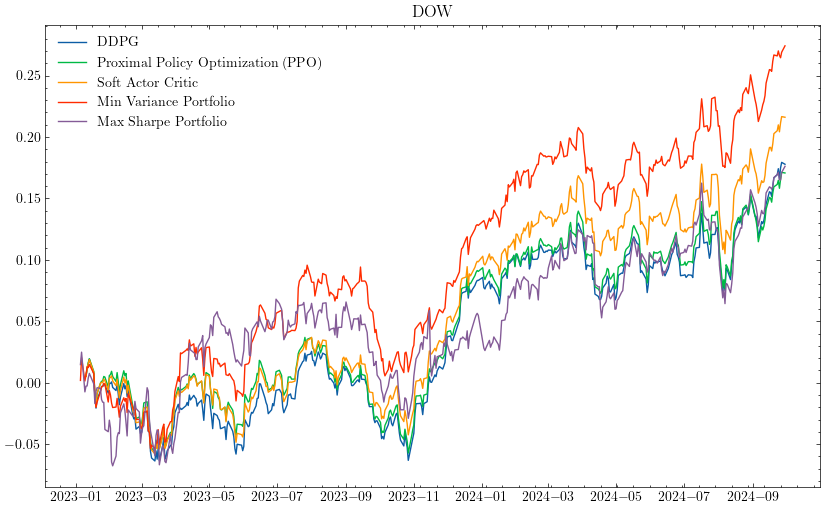

In [115]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW')

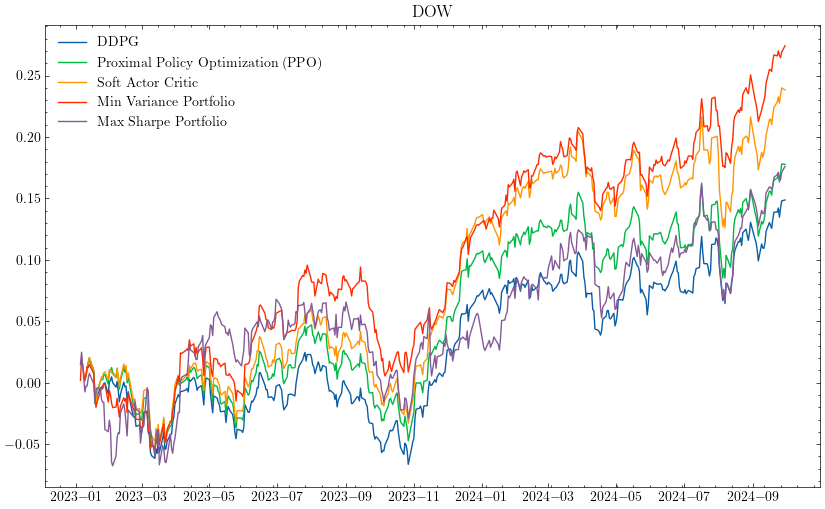

In [118]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW')

In [119]:
iterations = 80_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',use_sortino=True,tag='sortino_1')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,use_sortino=True,tag='sortino_1')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,use_sortino=True,tag='sortino_1')


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
[0, 0.0033532812499998954]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

KeyboardInterrupt: 

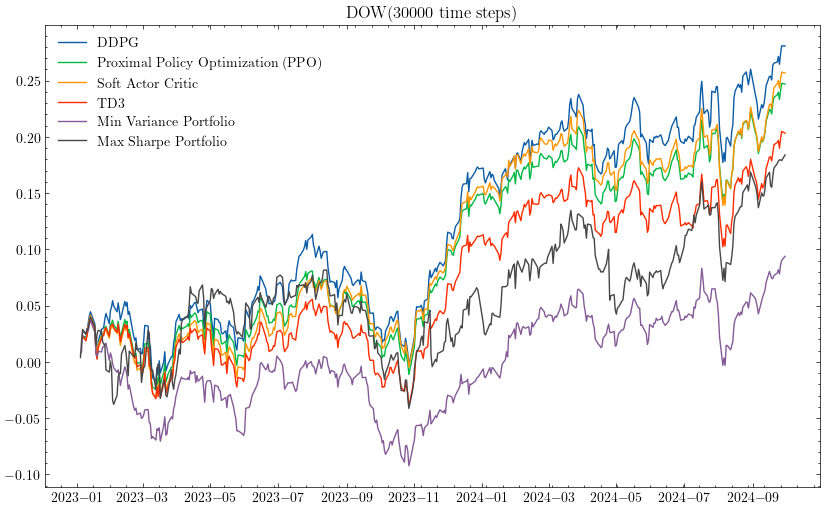

In [50]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [ ]:
iterations = 60_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=True,tag='dow30')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='dow30')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=True,tag='dow30')

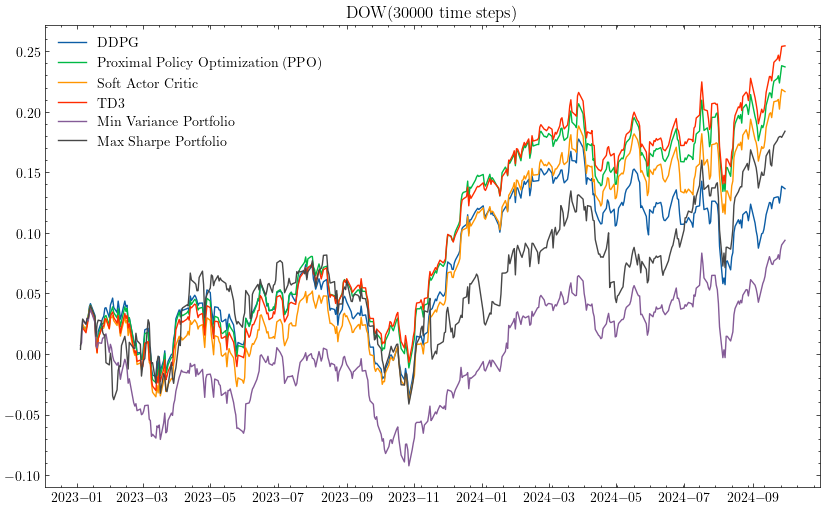

In [52]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [115]:
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1_000_000,load=True,tag='dow30')

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 16350.5009765625
Final accumulative portfolio value: 2.0438126220703126
hit end!


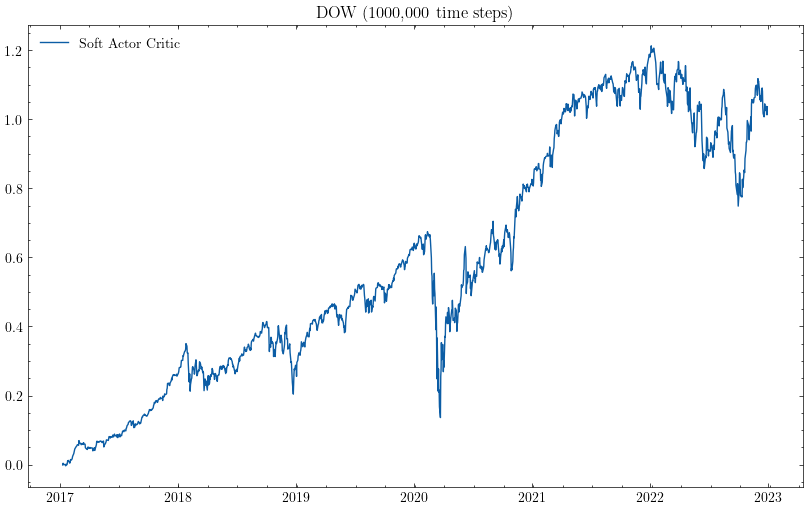

In [79]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')

    plt.legend()
    plt.title('DOW (1000,000 time steps)')

In [113]:
len(train_data.tic.unique().tolist())


29

In [120]:
weights = pd.DataFrame(result_sac['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.insert(0,'Cash')
weights.columns = columns
columns.append('date')
weights['date'] = result_sac['test'][0].date
# weights["sum"] = weights.drop(columns=["date"]).sum(axis=1)
weights

Cash      AAPL      AMGN       AXP        BA       CAT       CRM  \
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.032191  0.034153  0.034244  0.033971  0.034971  0.033546  0.034559   
2     0.031988  0.034094  0.033579  0.033554  0.034690  0.033126  0.035197   
3     0.032275  0.034078  0.034077  0.033675  0.034667  0.032883  0.034393   
4     0.032134  0.033995  0.034371  0.033485  0.034887  0.033137  0.034722   
...        ...       ...       ...       ...       ...       ...       ...   
1500  0.032504  0.033639  0.034455  0.033468  0.033747  0.032777  0.034571   
1501  0.032009  0.033836  0.033896  0.033823  0.034773  0.033148  0.034414   
1502  0.032129  0.033615  0.034102  0.033404  0.034781  0.033413  0.034824   
1503  0.032570  0.033473  0.034403  0.033444  0.035001  0.032904  0.034324   
1504  0.031787  0.034630  0.034058  0.034001  0.034485  0.032729  0.035228   

          CSCO       CVX       DIS  ...      MSFT       NKE        PG  \
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1     0.034086  0.033778  0.034174  ...  0.032560  0.033517  0.032666   
2     0.033385  0.034087  0.034343  ...  0.032654  0.033221  0.032940   
3     0.033817  0.034174  0.033681  ...  0.032364  0.033579  0.033160   
4     0.033855  0.034037  0.034310  ...  0.032565  0.033959  0.033022   
...        ...       ...       ...  ...       ...       ...       ...   
1500  0.033930  0.033759  0.034429  ...  0.032008  0.034254  0.033399   
1501  0.033807  0.034915  0.034515  ...  0.032481  0.033310  0.032943   
1502  0.033782  0.034358  0.033512  ...  0.032262  0.033992  0.033224   
1503  0.033924  0.033911  0.033659  ...  0.032609  0.033324  0.032978   
1504  0.033768  0.033882  0.034982  ...  0.033079  0.033946  0.032738   

           TRV       UNH         V        VZ       WBA       WMT       date  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 2017-01-09  
1     0.032472  0.033983  0.032580  0.032145  0.033414  0.032884 2017-01-10  
2     0.032453  0.033930  0.032757  0.031774  0.033904  0.033081 2017-01-11  
3     0.032357  0.034251  0.032671  0.032340  0.033282  0.032942 2017-01-12  
4     0.032539  0.033887  0.032595  0.031960  0.033292  0.032662 2017-01-13  
...        ...       ...       ...       ...       ...       ...        ...  
1500  0.032454  0.034307  0.032725  0.032866  0.033565  0.033022 2022-12-22  
1501  0.032729  0.034142  0.032653  0.031968  0.033365  0.033024 2022-12-23  
1502  0.032628  0.034038  0.032761  0.032772  0.033061  0.033081 2022-12-27  
1503  0.032492  0.034224  0.032900  0.032081  0.033078  0.032900 2022-12-28  
1504  0.032312  0.033705  0.032811  0.032080  0.032888  0.032877 2022-12-29  

[1505 rows x 31 columns]

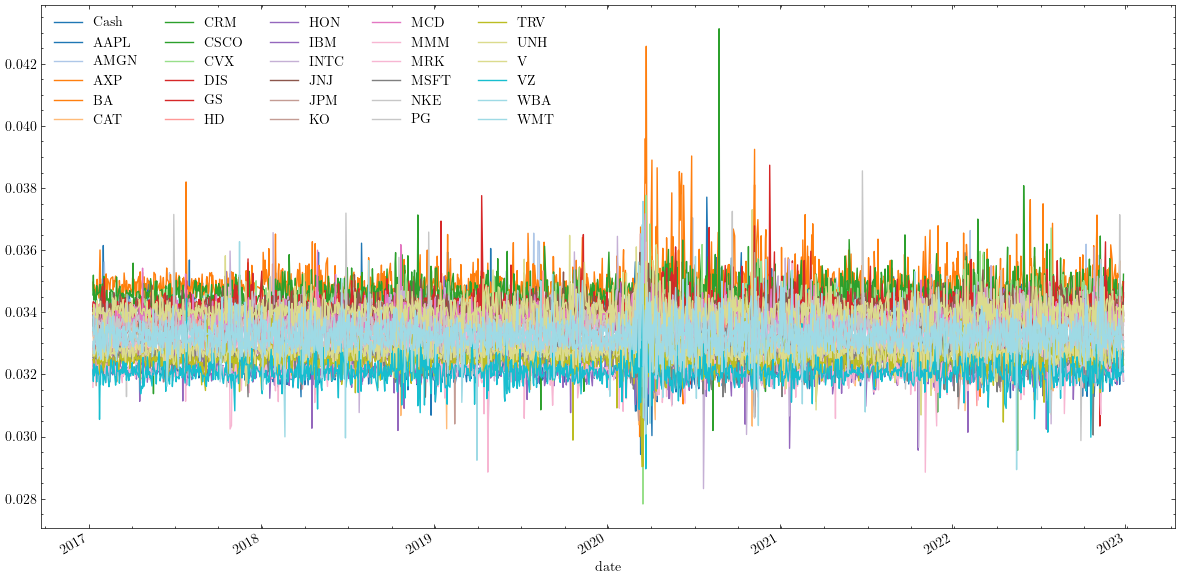

max drowdown: -0.32274258980341164 Sharp ratio: 0.7270892544556627


In [128]:
with plt.style.context('science','ieee'):
    # w.iloc[1:,].plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="summer").legend(ncol=5,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    weights.iloc[1:,].plot(x='date',figsize=(12,6),colormap="tab20")
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()
    print('max drowdown:', qs.stats.max_drawdown(result_sac['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_sac['test'][0].daily_return))


In [142]:
iterations = 120_000
result_ddpg = train_model(train_data,train_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',load=True,tag='dow30')
result_ppo = train_model(train_data,train_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='dow30')
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1000000,load=True,tag='dow30')
result_td3 = train_model(train_data,train_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='dow30')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 16152.1806640625
Final accumulative portfolio value: 2.0190225830078123
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 14687.2021484375
Final accumulative portfolio value: 1.8359002685546875
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 15100.9013671875
Final accumulative portfolio value: 1.8876126708984375
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 15126.587890625
Final accumulative portfolio value: 1.890823486328125
hit end!


In [140]:
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=1000000,load=True,tag='dow30')


{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9068.279296875
Final accumulative portfolio value: 1.133534912109375
hit end!


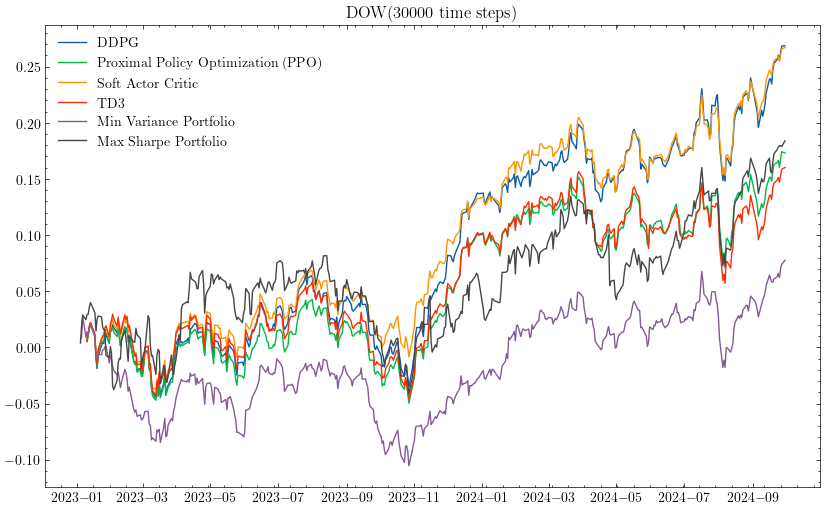

In [134]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

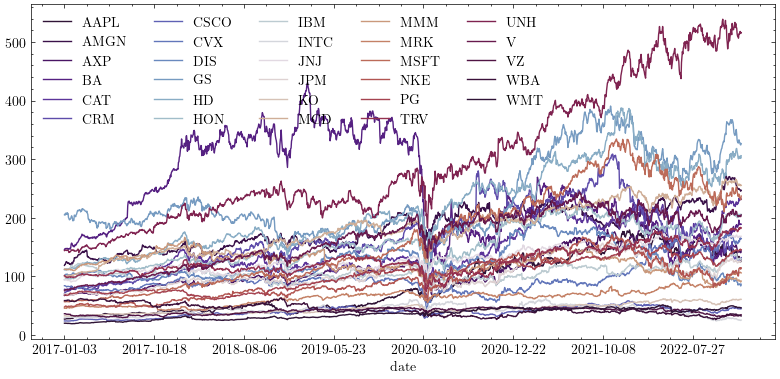

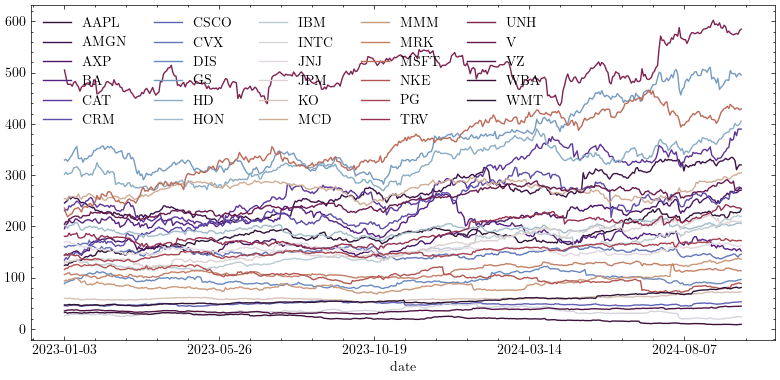

In [9]:
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = train_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    

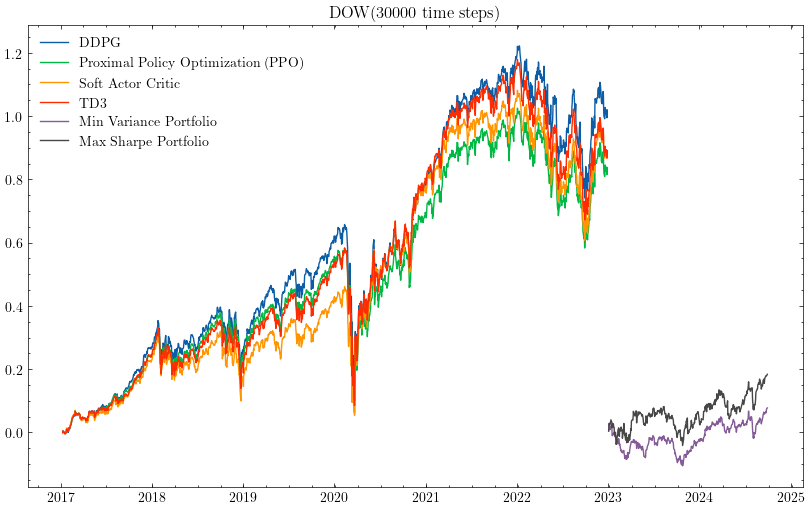

In [ ]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [16]:
iterations = 120_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',load=True,tag='dow30_sharpe',use_sharpe=True)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='dow30_sharpe',use_sharpe=True)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,load=True,tag='dow30_sharpe',use_sharpe=True)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='dow30_sharpe',use_sharpe=True)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10291.1943359375
Final accumulative portfolio value: 1.2863992919921876
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9424.6005859375
Final accumulative portfolio value: 1.1780750732421874
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9637.515625
Final accumulative portfolio value: 1.204689453125
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9447.6650390625
Final accumulative portfolio value: 1.1809581298828125
hit end!


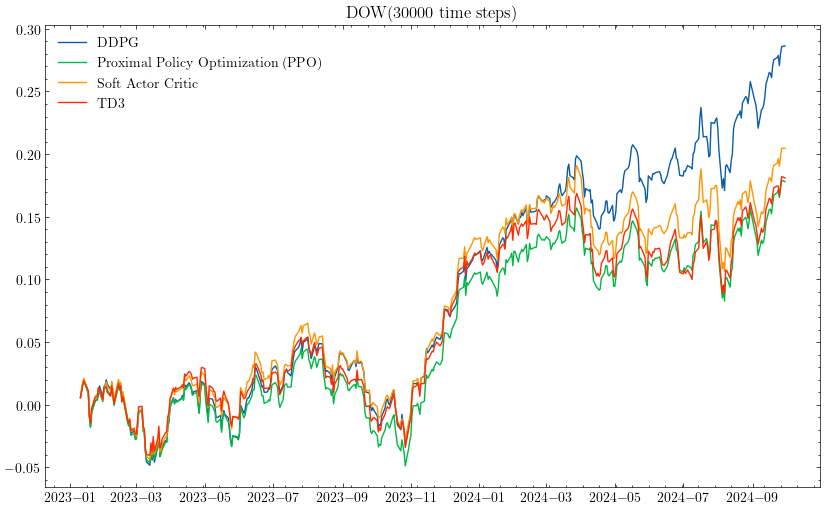

In [17]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [11]:
# encoding: utf-8
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

dt = df_sp500.query("date> '2005-01-01'")['close']
pct = dt.pct_change().ffill().fillna(0.0)
pct = pct.values

def sharpe(ls):
    return np.mean(ls)/np.std(ls)

freq = 252
ls1 = []
sr0 = sharpe(pct[:freq])
for i in range(500):
    sr = sharpe(pct[:freq+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# ls2 uses cumulated DSR to approximate SR 
ls2 = []
eta = 0.002
# use the first 200 days to set an initial value of SR
sr = sharpe(pct[:freq]) 
print(sr)
for i in range(500):
    A = np.mean(pct[:freq+i])
    B = np.mean(pct[:freq+i]**2)
    delta_A = pct[freq+i+1] - A
    delta_B = pct[freq+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    print(Dt*eta)
    sr += eta * Dt
    ls2.append(Dt*eta)

0.22922770463572564
-0.0005161285309821036
-0.00020637156973838712
6.487055902451664e-05
-0.00020049524177508465
-0.00014711270704077757
-0.0004794518842692132
-0.0006944420291596554
-0.019358018493164403
-0.00037820220439200545
0.0002811699868600998
-0.00048469773108922456
0.0012038274864825246
-0.0004097042637077974
0.00013515966795319917
-0.000312446165623296
-0.00019108469319602226
-0.0003215429874165384
-0.0002161466986848402
0.00026778938181864364
-0.0004309630567890684
0.0001389186828107922
-8.961606584280944e-05
-0.0004256610416367961
0.00040545994951341407
-0.00030284675374853484
-0.0004042594869766843
4.170891099327931e-05
-4.103254426767599e-05
-0.00034390049751309833
-0.00024351162289191865
-0.0001511408459291697
-0.0003952160968980469
-0.00010815349284304511
0.00016661352786297542
-0.00021720630763548892
-0.00023646254162261004
-0.00045608890656645087
0.000605539850966313
-1.3183500029932025e-05
-0.0003633847578975285
-0.00043389283306529515
0.0001705064195268933
-0.000198

In [12]:
iterations = 120_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',tag='dow30_dsr',use_dsr=True)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
result_ppo = train_model(train_data,train_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='dow30')
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1000000,load=True,tag='dow30')
result_td3 = train_model(train_data,train_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='dow30')

In [15]:
returns = np.random.normal(loc=0.01, scale=0.02, size=1000)  # Mean 1%, Std Dev 2%


In [45]:
ls2 = []
freq = 252
eta = 0.0001
ls1 = []
sr0 = sharpe(returns[:freq])
for i in range(747):
    sr = sharpe(returns[:freq+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# use the first 200 days to set an initial value of SR
sr = sharpe(returns[:freq]) 
for i in range(747):
    A = np.mean(returns[:freq+i])
    B = np.mean(returns[:freq+i]**2)
    delta_A = returns[freq+i+1] - A
    delta_B = returns[freq+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    sr += eta * Dt
    ls2.append(Dt*eta)

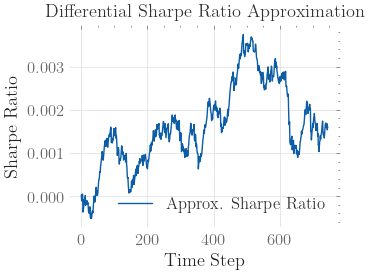

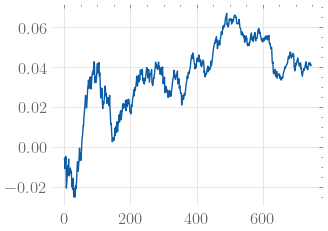

In [46]:

plt.plot(np.array(ls2).cumsum(), label="Approx. Sharpe Ratio")

plt.title("Differential Sharpe Ratio Approximation")
plt.xlabel("Time Step")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()
plt.plot(np.array(ls1).cumsum(), label=" Sharpe Ratio")
plt.show()


In [62]:
# encoding: utf-8
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

pct = df_sp500['close'].pct_change().ffill().fillna(0.0)
pct = returns

def sharpe(ls):
    return np.mean(ls)/np.std(ls)

# ls1 contains the true SR values
ls1 = []
feq = 100
sr0 = sharpe(pct[:freq])
for i in range(500):
    sr = sharpe(pct[:freq+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# ls2 uses cumulated DSR to approximate SR 
ls2 = []
eta = 0.001
# use the first freq days to set an initial value of SR
sr = sharpe(pct[:freq]) 
for i in range(500):
    A = np.mean(pct[:freq+i])
    B = np.mean(pct[:freq+i]**2)
    delta_A = pct[freq+i+1] - A
    delta_B = pct[freq+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    sr += eta * Dt
    ls2.append(Dt*eta)
print(sr)
print(sr0)


0.5084640695477123
0.537442748271409


# DAX

In [123]:
INDICATORS = [
    "close_21_ema",
    'macd',
    'rsi'
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dax[df_dax["date"] > TRAIN_START_DATE])
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 19, State Space: 96


In [128]:
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)
min_variance_portfolio = mvo(covs,pct=0,rf=0)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0,rf=0)

begin_total_asset:50000
end_total_asset:68170.34600166662
Sharpe:  1.7777986611606376
Test Finished!
episode_return 1.3634069200333325
begin_total_asset:50000
end_total_asset:66009.86561799965
Sharpe:  1.3608817492753051
Test Finished!
episode_return 1.320197312359993


In [90]:
stock_dimension = len(test_data.tic.unique())

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=50_000,
    comission_fee_pct=0.001,
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Episode:1
Initial portfolio value:50000
Final portfolio value: 64170.66796875
Final accumulative portfolio value: 1.283413359375


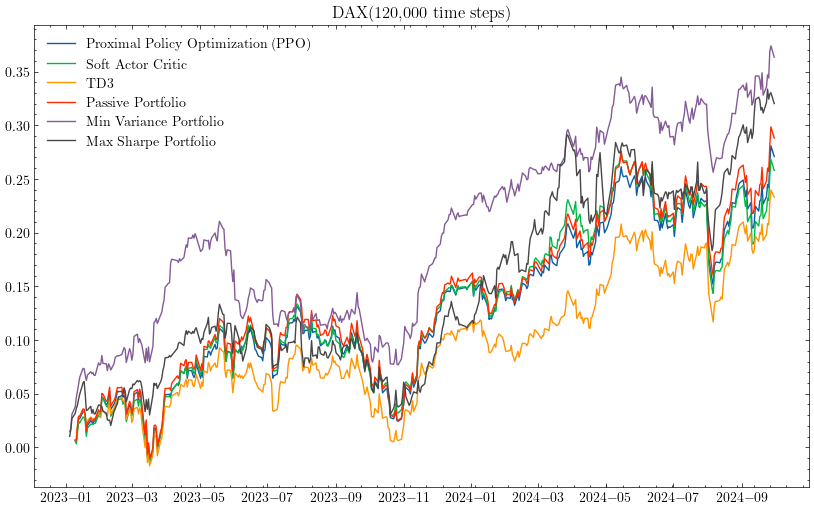

In [141]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod()-1,label = 'Passive Portfolio')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [ ]:
iterations = 120_000
result_ddpg =train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,iterations=iterations,model_name='ddpg',tag='dax_SHARPE')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,model_name='ppo',iterations=iterations,tag='dax_SHARPE')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,model_name='sac',iterations=iterations,tag='dax_SHARPE')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,model_name='td3',iterations=iterations,tag='dax_SHARPE')

In [131]:
iterations = 120_000
result_ddpg =train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],use_sharpe=True,load=True,iterations=iterations,model_name='ddpg',tag='dax_SHARPE_indicators')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],use_sharpe=True,load=True,model_name='ppo',iterations=iterations,tag='dax_SHARPE_indicators')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],use_sharpe=True,load=True,model_name='sac',iterations=iterations,tag='dax_SHARPE_indicators')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],use_sharpe=True,load=True,model_name='td3',iterations=iterations,tag='dax_SHARPE_indicators')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 63827.2890625
Final accumulative portfolio value: 1.27654578125
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 63543.8046875
Final accumulative portfolio value: 1.27087609375
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 62899.75
Final accumulative portfolio value: 1.257995
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 61652.5625
Final accumulative portfolio value: 1.23305125
hit end!


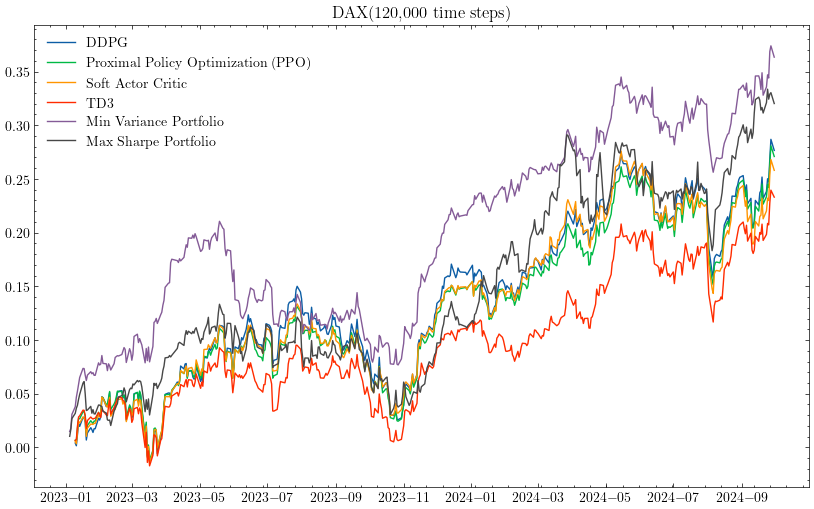

In [132]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [ ]:
iterations = 120_000
result_ddpg =train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],iterations=iterations,model_name='ddpg',tag='daxreturn__indicators')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],model_name='ppo',iterations=iterations,tag='dax_return_indicators')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],model_name='sac',iterations=iterations,tag='dax_return_indicators')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,features=["close","log_return","rsi","close_21_ema"],model_name='td3',iterations=iterations,tag='dax_return_indicators')

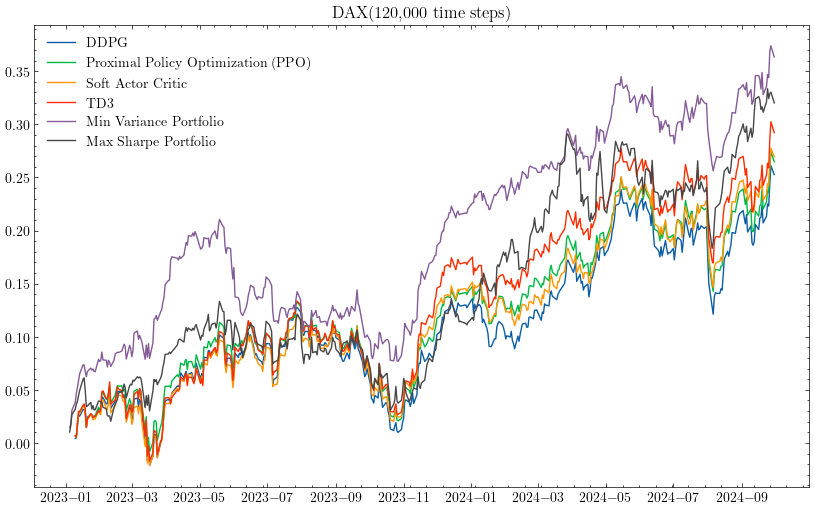

In [130]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

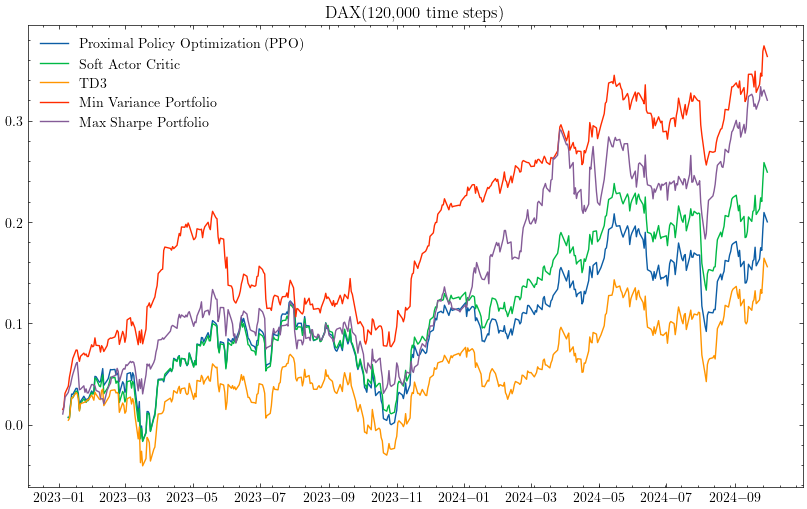

In [103]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

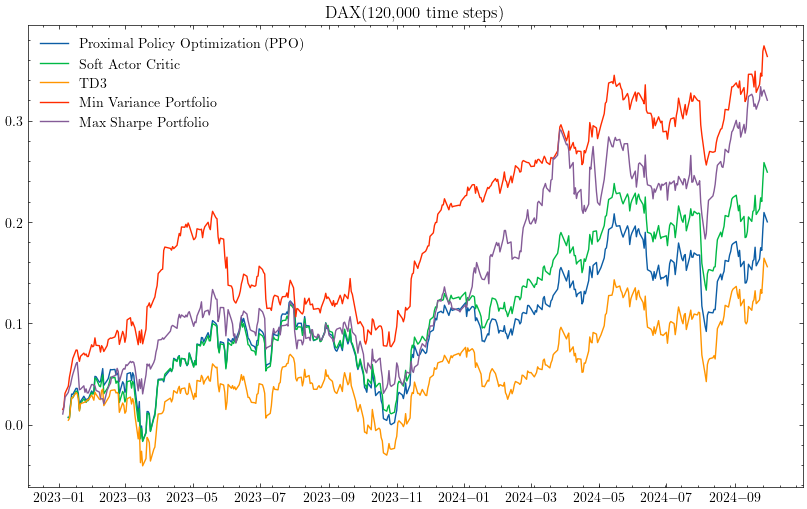

In [100]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

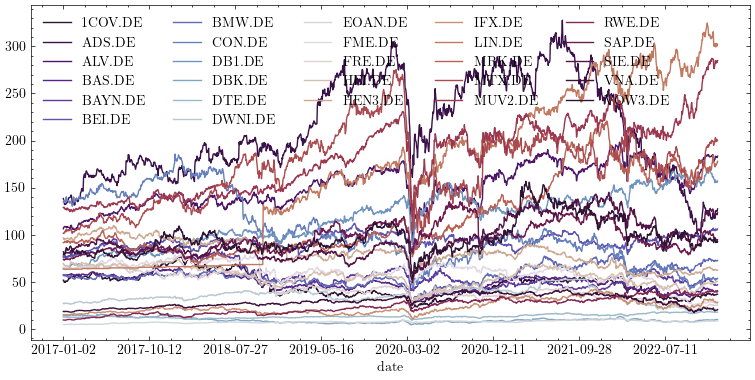

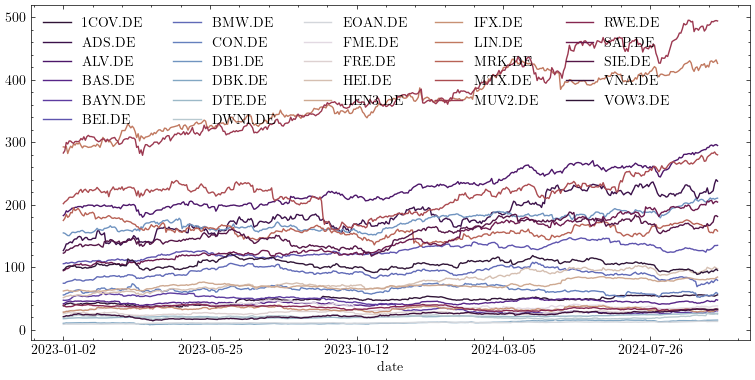

In [21]:
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = train_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    

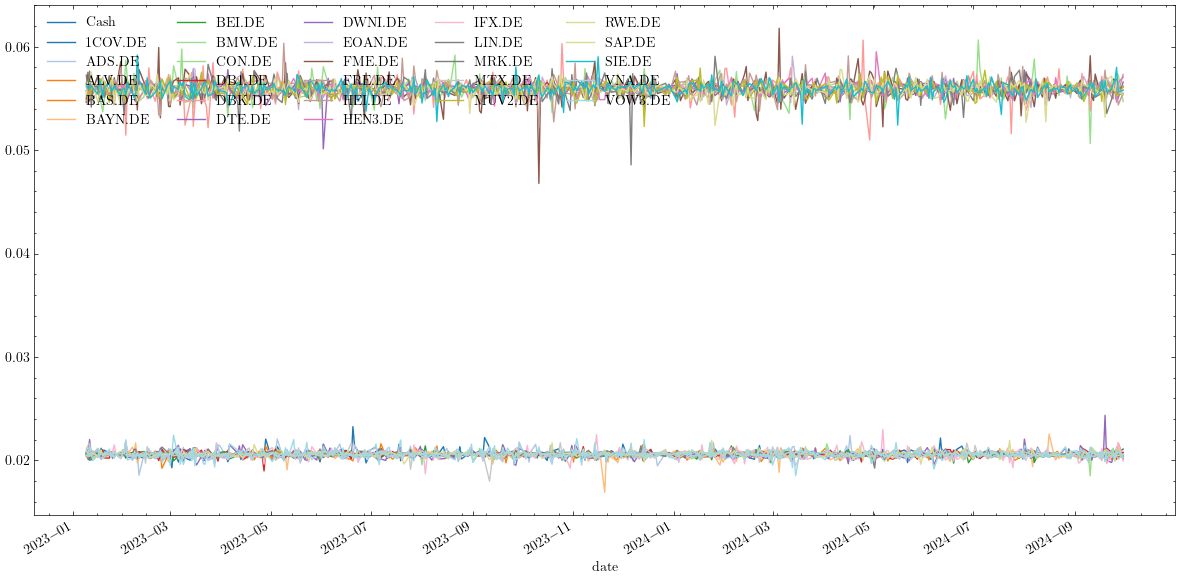

max drowdown: -0.09788244842901161 Sharp ratio: 1.3919193545781623


In [24]:
weights = pd.DataFrame(result_ddpg['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.insert(0,'Cash')
weights.columns = columns
columns.append('date')
weights['date'] = result_ddpg['test'][0].date
# weights["sum"] = weights.drop(columns=["date"]).sum(axis=1)
weights
with plt.style.context('science','ieee'):
    # w.iloc[1:,].plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="summer").legend(ncol=5,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    weights.iloc[1:,].plot(x='date',figsize=(12,6),colormap="tab20")
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()
    print('max drowdown:', qs.stats.max_drawdown(result_ddpg['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_ddpg['test'][0].daily_return))


In [25]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_sp500)
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 236, State Space: 709


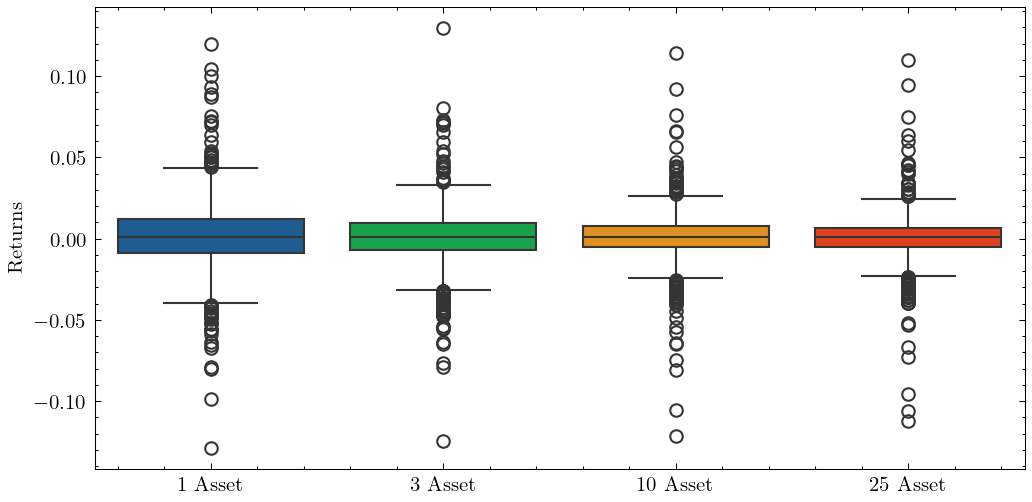

In [80]:
import seaborn as sns
df = processed_dax[processed_dax.date>'2020-01-01'].copy()
pv = df.pivot(index='date',columns='tic',values='return')
%matplotlib inline
with plt.style.context('science','ieee'):
    fig = plt.figure(figsize=(8, 4), dpi=150)
    single_asset = pv['AAPL']
    portfolio_3 = pv.iloc[:, 0:3].mean(axis=1)
    portfolio_10 = pv.iloc[:, 0:10].mean(axis=1)
    portfolio_20 = pv.iloc[:, 0:50].mean(axis=1)

    # Combine the data into a DataFrame for easy plotting
    import pandas as pd
    data = pd.DataFrame({
        "1 Asset": single_asset,
        "3 Asset": portfolio_3,
        "10 Asset": portfolio_10,
        "25 Asset": portfolio_20
    })


    # Create the boxplot
    sns.boxplot(data=data, palette="Set2")

    plt.ylabel("Returns")
    plt.show()


In [91]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=100000,model_name='ddpg',save=True,tag='27dec')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=100000,save=True,tag='27dec')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=100000,save=True,tag='27dec')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=100000,save=True,tag='27dec')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Episode:1
Initial portfolio value:8000
Final portfolio value: 17409.62109375
Final accumulative portfolio value: 2.17620263671875
Episode:2
Initial portfolio value:8000
Final portfolio value: 17012.708984375
Final accumulative portfolio value: 2.126588623046875
Episode:3
Initial portfolio value:8000
Final portfolio value: 16505.921875
Final accumulative portfolio value: 2.063240234375
Episode:4
Initial portfolio value:8000
Final portfolio value: 17113.951171875
Final accumulative portfolio value: 2.139243896484375
Episode:5
Initial portfolio value:8000
Final portfolio value: 17258.734375
Final accumulative portfolio value: 2.157341796875
Episode:6
Initial portfolio value:8000
Final portfolio value: 18081.6171875
Final accumulative portfolio value: 2.2602021484375
Episode:7
Initial portfolio value:8000
Final portfolio value: 18482.54296875
Final accumulative portfolio value: 2.31031787109375
Episode:8
Initial portfolio va

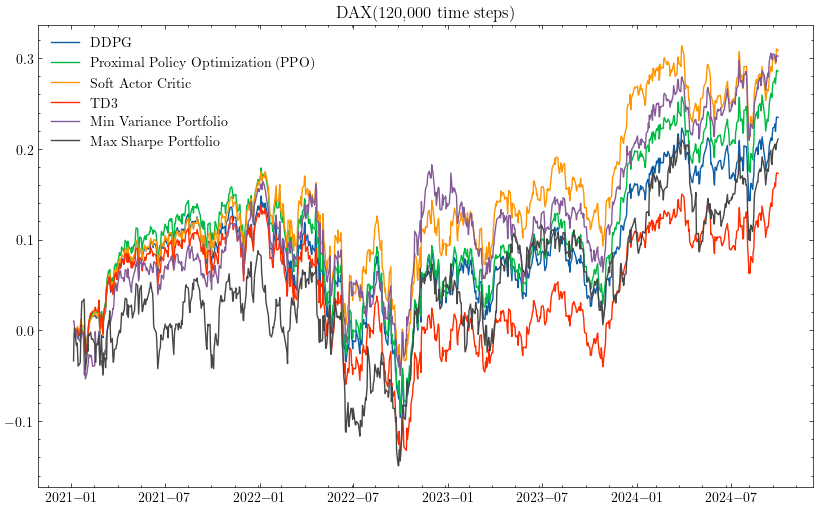

In [93]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [96]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 256,
}

In [97]:
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=500_000,save=True,tag='27dec',args=PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256}
Episode:1
Initial portfolio value:8000
Final portfolio value: 9098.7236328125
Final accumulative portfolio value: 1.1373404541015626
Episode:2
Initial portfolio value:8000
Final portfolio value: 9481.9052734375
Final accumulative portfolio value: 1.1852381591796874
Episode:3
Initial portfolio value:8000
Final portfolio value: 9004.09375
Final accumulative portfolio value: 1.12551171875
Episode:4
Initial portfolio value:8000
Final portfolio value: 8889.3916015625
Final accumulative portfolio value: 1.1111739501953124
Episode:5
Initial portfolio value:8000
Final portfolio value: 9078.318359375
Final accumulative portfolio value: 1.134789794921875
Episode:6
Initial portfolio value:8000
Final portfolio value: 9180.017578125
Final accumulative portfolio value: 1.147502197265625
Episode:7
Initial portfolio value:8000
Final portfolio value: 8927.8427734375
Final accumulative portfolio value: 1.1159803466796876
Ep

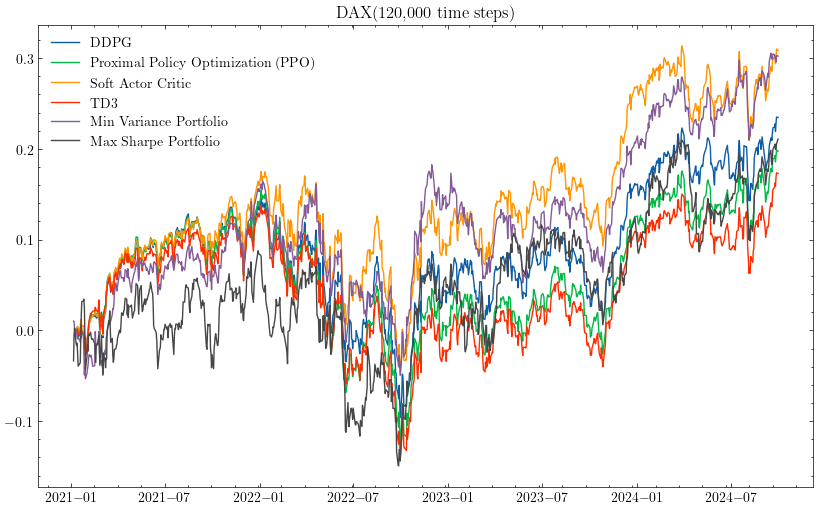

In [98]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [ ]:
iterations = 120_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',load=True,tag='29dec',t=1)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='29dec',t=1)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,load=True,tag='29dec',t=1)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='29dec',t=1)

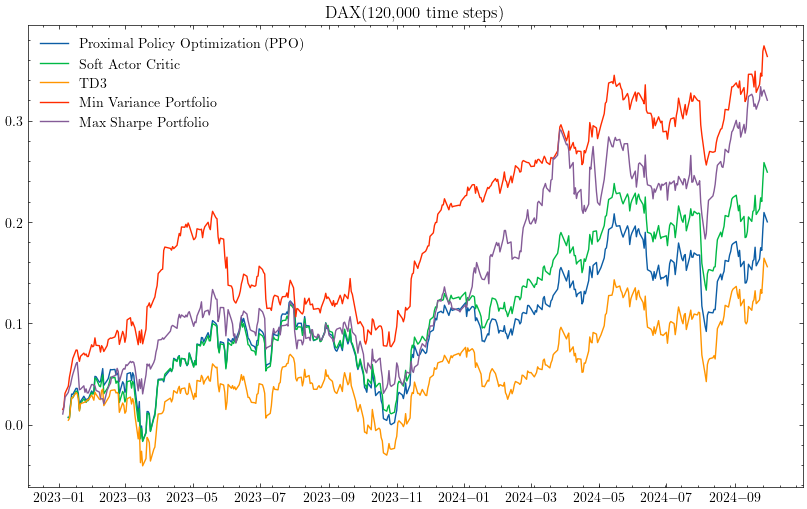

In [105]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [29]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
idx = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['dax']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (994, 8)


In [19]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=100000,model_name='ddpg',load=True,tag='29dec_t3',t=3)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=100000,load=True,tag='29dec_t3',t=3)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=100000,load=True,tag='29dec_t3',t=3)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=100000,load=True,tag='29dec_t3',t=3)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9927.658203125
Final accumulative portfolio value: 1.240957275390625
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9972.640625
Final accumulative portfolio value: 1.246580078125
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10896.1220703125
Final accumulative portfolio value: 1.3620152587890626
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10760.248046875
Final accumulative portfolio value: 1.345031005859375
hit end!


In [69]:
TEST_STARTD_DATE = '2023-01-01'
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)

In [60]:
z = covs[covs.time> TEST_STARTD_DATE]

In [77]:
min_variance_portfolio = mvo(z,pct=0,rf=0)

begin_total_asset:50000
end_total_asset:71657.21816787958
Sharpe:  2.1102407136517933
Test Finished!
episode_return 1.4331443633575915


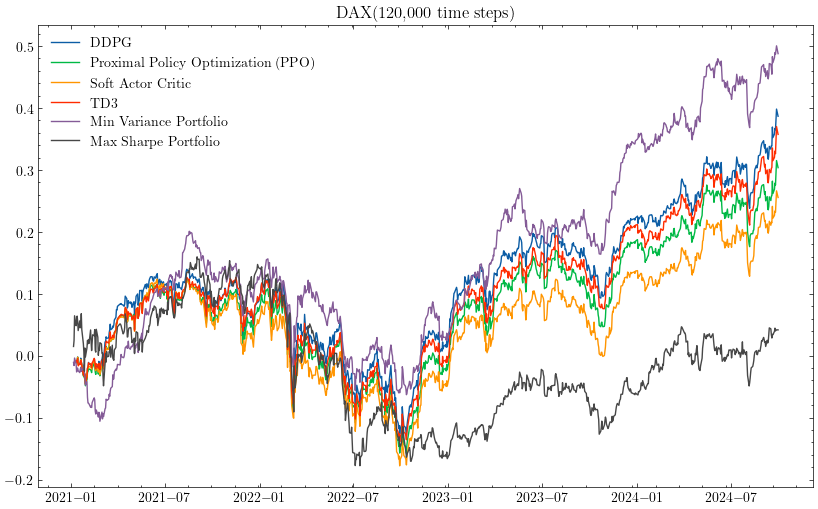

In [55]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')    
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [51]:
train_data[train_data.tic == "ADS.DE"].head(80)

Unnamed: 0        date       open       high        low      close  \
0        70960  2010-01-04  37.959999  38.525002  37.685001  31.563414   
1        70985  2010-01-05  39.000000  40.049999  38.820000  32.559383   
2        71010  2010-01-06  39.799999  40.064999  39.095001  32.297070   
3        71035  2010-01-07  39.365002  40.000000  39.115002  32.579872   
4        71060  2010-01-08  39.724998  39.994999  39.250000  32.461010   
..         ...         ...        ...        ...        ...        ...   
75       72835  2010-04-21  41.935001  42.799999  41.669998  34.870998   
76       72860  2010-04-22  42.665001  43.169998  41.799999  35.096416   
77       72885  2010-04-23  44.250000  44.910000  43.660000  36.473553   
78       72910  2010-04-26  44.775002  45.049999  44.500000  36.768654   
79       72935  2010-04-27  44.775002  45.154999  43.875000  36.035004   

     volume     tic  day  close_5_ema      macd         rsi    return  \
0    953276  ADS.DE    0    31.563414  0.000000  100.000000  0.031555   
1   2463075  ADS.DE    1    32.160995  0.022345  100.000000  0.031555   
2   1099488  ADS.DE    2    32.225452  0.020338   77.903769 -0.008056   
3   1085415  ADS.DE    3    32.372672  0.029137   82.415102  0.008756   
4    719621  ADS.DE    4    32.406584  0.028575   75.443194 -0.003648   
..      ...     ...  ...          ...       ...         ...       ...   
75  2137456  ADS.DE    2    34.330929  0.802772   71.921921  0.012857   
76  2918570  ADS.DE    3    34.586091  0.841808   73.332209  0.006464   
77  3365049  ADS.DE    4    35.215245  0.972400   79.955895  0.039239   
78  1120438  ADS.DE    0    35.733048  1.087117   81.042502  0.008091   
79  1216210  ADS.DE    1    35.833700  1.106191   70.770795 -0.019953   

    log_return  
0     0.031067  
1     0.031067  
2    -0.008089  
3     0.008718  
4    -0.003655  
..         ...  
75    0.012775  
76    0.006444  
77    0.038488  
78    0.008058  
79   -0.020155  

[80 rows x 14 columns]

In [ ]:
iterations = 200_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,load=True,iterations=iterations,model_name='ddpg',tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,load=True,model_name='ppo',iterations=iterations,tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])
result_sac = train_model(train_data,test_data,transaction_fee=0.001,load=True,model_name='sac',iterations=iterations,tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,load=True,model_name='td3',iterations=iterations,tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])

In [ ]:
iterations = 500_000
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='03jan',t=3)


In [133]:
stock_dimension = len(test_data.tic.unique())

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.0001,
    time_window=5,
    features = ["close", "high", "low"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Episode:1
Initial portfolio value:1000000
Final portfolio value: 1288028.5
Final accumulative portfolio value: 1.2880285


In [142]:
iterations = 500_000
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='03jan',t=3)


{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Episode:1
Initial portfolio value:50000
Final portfolio value: 39331.48046875
Final accumulative portfolio value: 0.786629609375
Episode:2
Initial portfolio value:50000
Final portfolio value: 49948.15234375
Final accumulative portfolio value: 0.998963046875
Episode:3
Initial portfolio value:50000
Final portfolio value: 48600.875
Final accumulative portfolio value: 0.9720175
Episode:4
Initial portfolio value:50000
Final portfolio value: 67975.7578125
Final accumulative portfolio value: 1.35951515625
Episode:5
Initial portfolio value:50000
Final portfolio value: 65405.12890625
Final accumulative portfolio value: 1.308102578125
Episode:6
Initial portfolio value:50000
Final portfolio value: 109315.0390625
Final accumulative portfolio value: 2.18630078125
Episode:7
Initial portfolio value:50000
Final portfolio value: 134755.875
Final accumulative portfolio value: 2.6951175
Epis

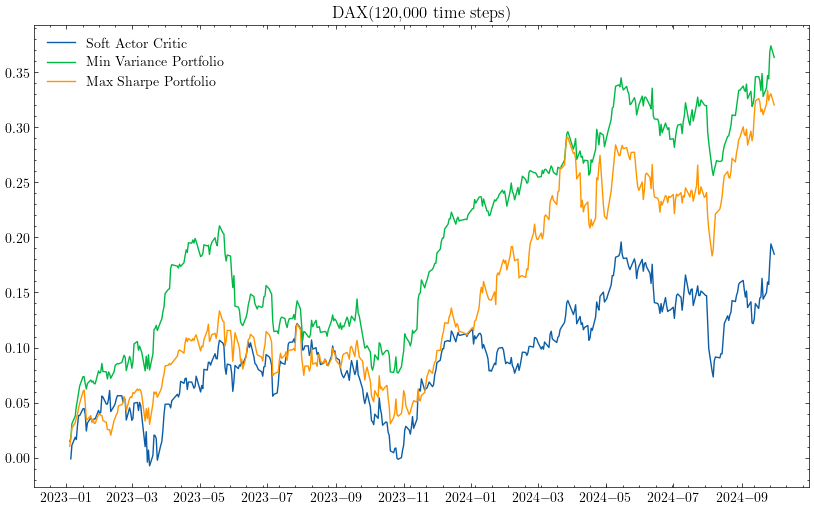

In [143]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')    
    plt.legend()
    plt.title('DAX(120,000 time steps)')

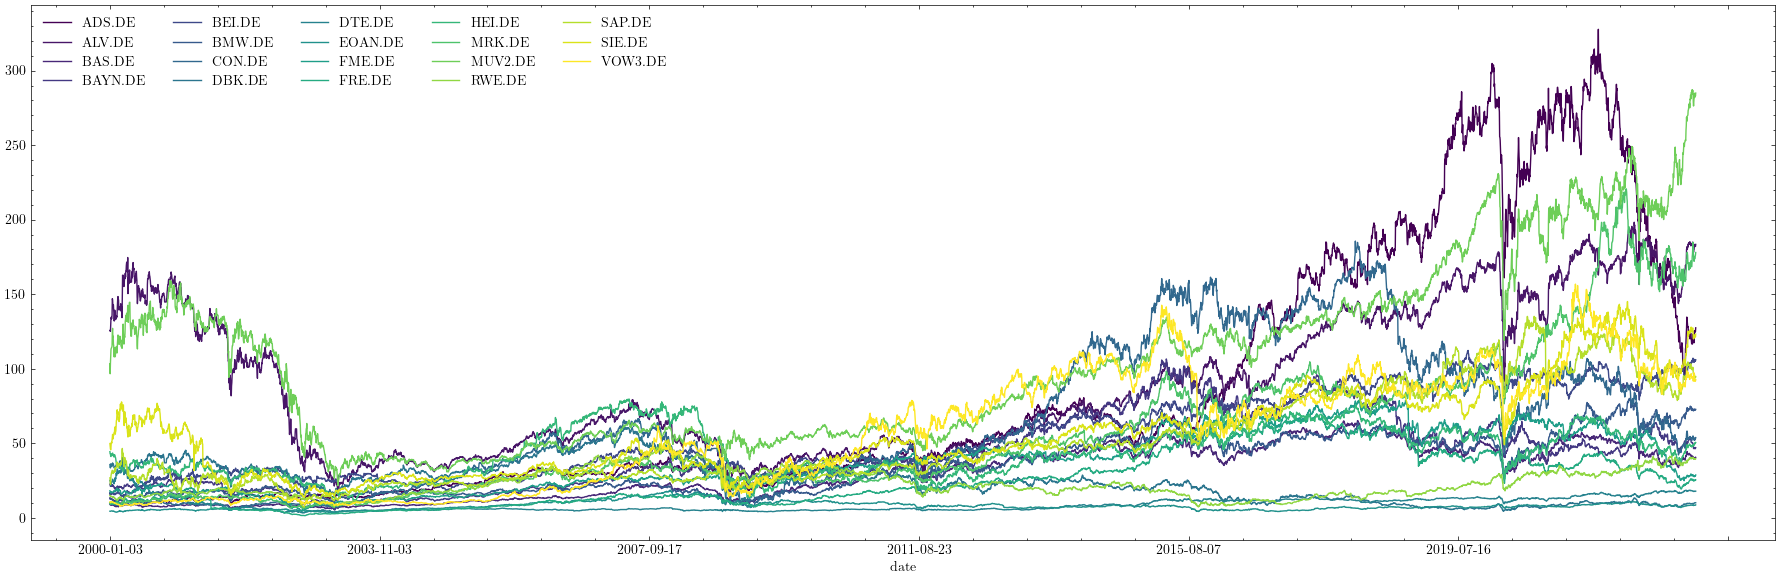

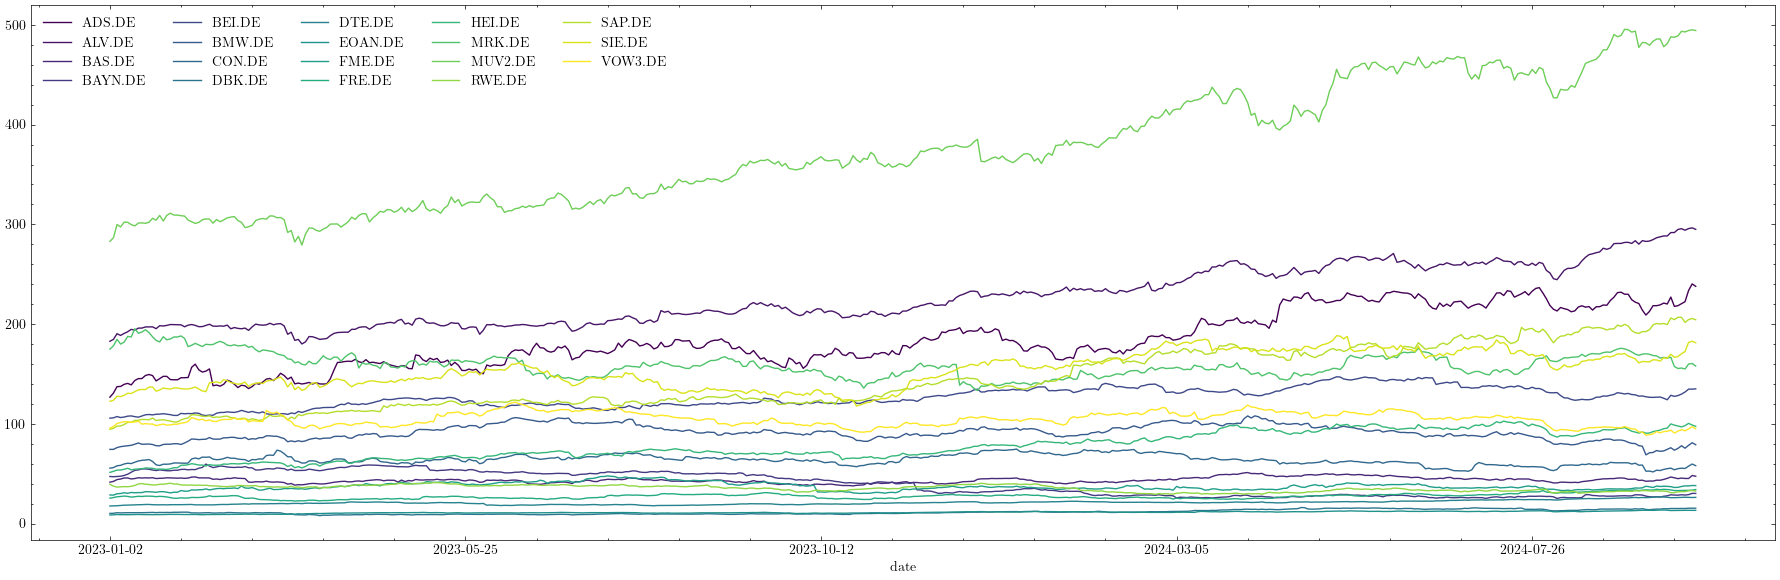

In [167]:
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = train_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(18,6),colormap='viridis')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(18,6),colormap='viridis')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
 
    

In [165]:
pv = train_data.pivot(values='log_return',columns='tic',index='date')


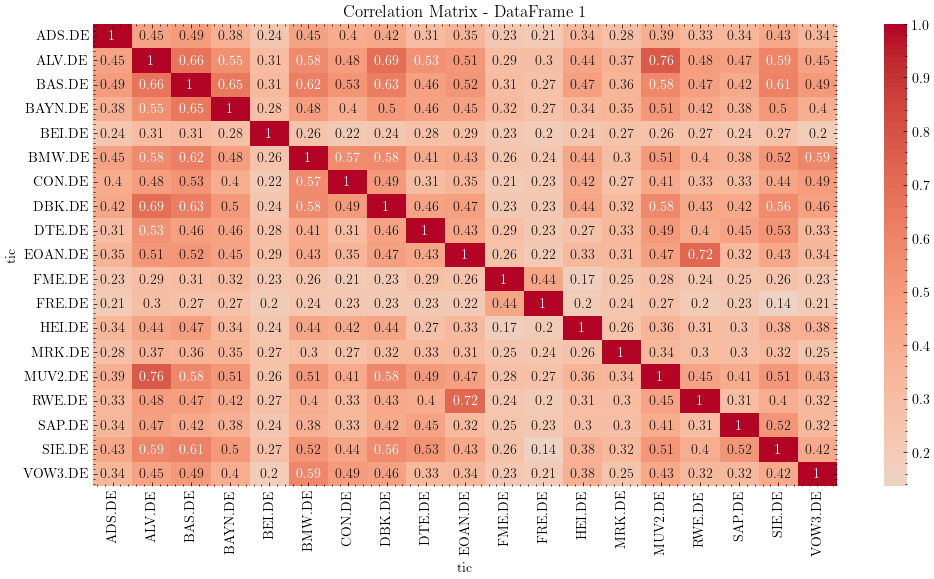

In [166]:
import seaborn as sns
train_correlation = pv.corr()
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_correlation, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix - DataFrame 1")
    plt.show()


In [189]:
threshold = 0.5
pv = train_data.pivot(values='log_return',columns='tic',index='date')
train_correlation = pv.corr()
display(train_correlation)
high_corr_pairs = np.where(abs(train_correlation) > threshold)

stocks_to_drop = set()
for i, j in zip(*high_corr_pairs):
    if i != j:  
        stock_1 = train_correlation.columns[i]
        stock_2 = train_correlation.columns[j]
        stocks_to_drop.add(stock_2)

# Drop the identified stocks
cleaned_stock_returns = train_correlation.drop(columns=stocks_to_drop)

# Optionally: recheck the correlation matrix to ensure all correlations are below threshold
cleaned_correlation_matrix = cleaned_stock_returns.corr()
display(cleaned_correlation_matrix)


tic        ADS.DE    ALV.DE    BAS.DE   BAYN.DE    BEI.DE    BMW.DE    CON.DE  \
tic                                                                             
ADS.DE   1.000000  0.447788  0.490172  0.382846  0.237555  0.449542  0.404232   
ALV.DE   0.447788  1.000000  0.663020  0.548437  0.307216  0.575062  0.478479   
BAS.DE   0.490172  0.663020  1.000000  0.649825  0.313570  0.618994  0.530123   
BAYN.DE  0.382846  0.548437  0.649825  1.000000  0.283198  0.479412  0.396475   
BEI.DE   0.237555  0.307216  0.313570  0.283198  1.000000  0.259230  0.219260   
BMW.DE   0.449542  0.575062  0.618994  0.479412  0.259230  1.000000  0.566564   
CON.DE   0.404232  0.478479  0.530123  0.396475  0.219260  0.566564  1.000000   
DBK.DE   0.424607  0.689168  0.632439  0.499206  0.235725  0.577780  0.493131   
DTE.DE   0.309429  0.533523  0.464316  0.459015  0.278003  0.408623  0.306209   
EOAN.DE  0.353580  0.514335  0.515244  0.447349  0.286301  0.427365  0.353092   
FME.DE   0.232285  0.288990  0.305767  0.318078  0.232016  0.257623  0.209090   
FRE.DE   0.208571  0.295557  0.274878  0.268410  0.197960  0.244326  0.233662   
HEI.DE   0.338340  0.440824  0.474642  0.341001  0.235451  0.438339  0.422091   
MRK.DE   0.279486  0.369601  0.355396  0.354030  0.266834  0.301736  0.268747   
MUV2.DE  0.388898  0.764489  0.584105  0.513776  0.259242  0.505254  0.413473   
RWE.DE   0.331217  0.478579  0.472584  0.421887  0.273846  0.396727  0.330057   
SAP.DE   0.340811  0.469974  0.419965  0.382172  0.238596  0.378294  0.327195   
SIE.DE   0.430056  0.594937  0.610391  0.496070  0.273647  0.520375  0.442680   
VOW3.DE  0.343532  0.448706  0.493826  0.396403  0.196646  0.586091  0.486810   

tic        DBK.DE    DTE.DE   EOAN.DE    FME.DE    FRE.DE    HEI.DE    MRK.DE  \
tic                                                                             
ADS.DE   0.424607  0.309429  0.353580  0.232285  0.208571  0.338340  0.279486   
ALV.DE   0.689168  0.533523  0.514335  0.288990  0.295557  0.440824  0.369601   
BAS.DE   0.632439  0.464316  0.515244  0.305767  0.274878  0.474642  0.355396   
BAYN.DE  0.499206  0.459015  0.447349  0.318078  0.268410  0.341001  0.354030   
BEI.DE   0.235725  0.278003  0.286301  0.232016  0.197960  0.235451  0.266834   
BMW.DE   0.577780  0.408623  0.427365  0.257623  0.244326  0.438339  0.301736   
CON.DE   0.493131  0.306209  0.353092  0.209090  0.233662  0.422091  0.268747   
DBK.DE   1.000000  0.457951  0.466259  0.227800  0.225183  0.443857  0.317580   
DTE.DE   0.457951  1.000000  0.434126  0.287086  0.227614  0.271405  0.331158   
EOAN.DE  0.466259  0.434126  1.000000  0.264054  0.218860  0.326670  0.312997   
FME.DE   0.227800  0.287086  0.264054  1.000000  0.444354  0.171427  0.250884   
FRE.DE   0.225183  0.227614  0.218860  0.444354  1.000000  0.199251  0.241621   
HEI.DE   0.443857  0.271405  0.326670  0.171427  0.199251  1.000000  0.261914   
MRK.DE   0.317580  0.331158  0.312997  0.250884  0.241621  0.261914  1.000000   
MUV2.DE  0.578682  0.494738  0.469892  0.280588  0.268661  0.358282  0.341709   
RWE.DE   0.428046  0.401154  0.720991  0.240832  0.201584  0.310154  0.304305   
SAP.DE   0.420080  0.452781  0.319942  0.251551  0.225320  0.297953  0.297081   
SIE.DE   0.562732  0.525390  0.427564  0.263208  0.136800  0.379475  0.323909   
VOW3.DE  0.461283  0.333931  0.337995  0.232975  0.207857  0.380719  0.248723   

tic       MUV2.DE    RWE.DE    SAP.DE    SIE.DE   VOW3.DE  
tic                                                        
ADS.DE   0.388898  0.331217  0.340811  0.430056  0.343532  
ALV.DE   0.764489  0.478579  0.469974  0.594937  0.448706  
BAS.DE   0.584105  0.472584  0.419965  0.610391  0.493826  
BAYN.DE  0.513776  0.421887  0.382172  0.496070  0.396403  
BEI.DE   0.259242  0.273846  0.238596  0.273647  0.196646  
BMW.DE   0.505254  0.396727  0.378294  0.520375  0.586091  
CON.DE   0.413473  0.330057  0.327195  0.442680  0.486810  
DBK.DE   0.578682  0.428046  0.420080  0.562732  0.46128

tic       ADS.DE    BEI.DE    FME.DE    FRE.DE    HEI.DE    MRK.DE
tic                                                               
ADS.DE  1.000000 -0.194622 -0.284189 -0.309434  0.155476 -0.109192
BEI.DE -0.194622  1.000000 -0.122314 -0.178317 -0.182342 -0.049418
FME.DE -0.284189 -0.122314  1.000000  0.459746 -0.417986 -0.129189
FRE.DE -0.309434 -0.178317  0.459746  1.000000 -0.315281 -0.131311
HEI.DE  0.155476 -0.182342 -0.417986 -0.315281  1.000000 -0.140686
MRK.DE -0.109192 -0.049418 -0.129189 -0.131311 -0.140686  1.000000

In [197]:
d = train_data[train_data.tic.isin(cleaned_correlation_matrix.columns)]

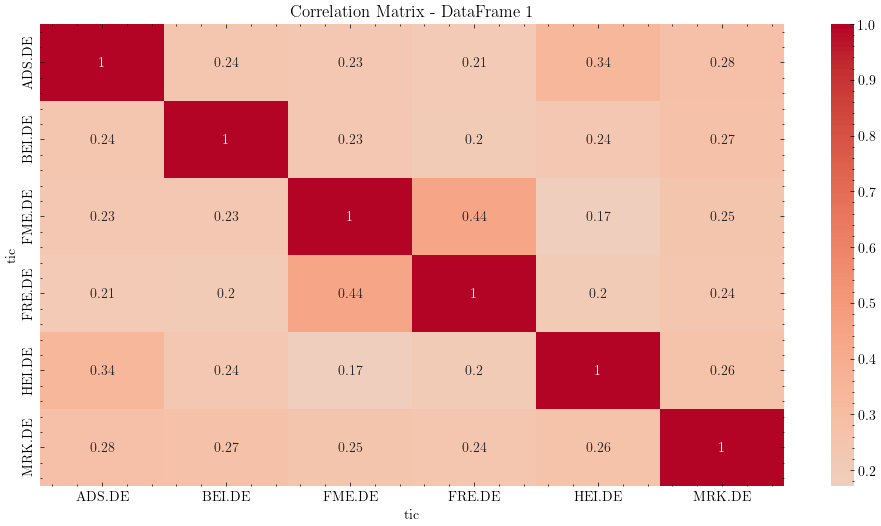

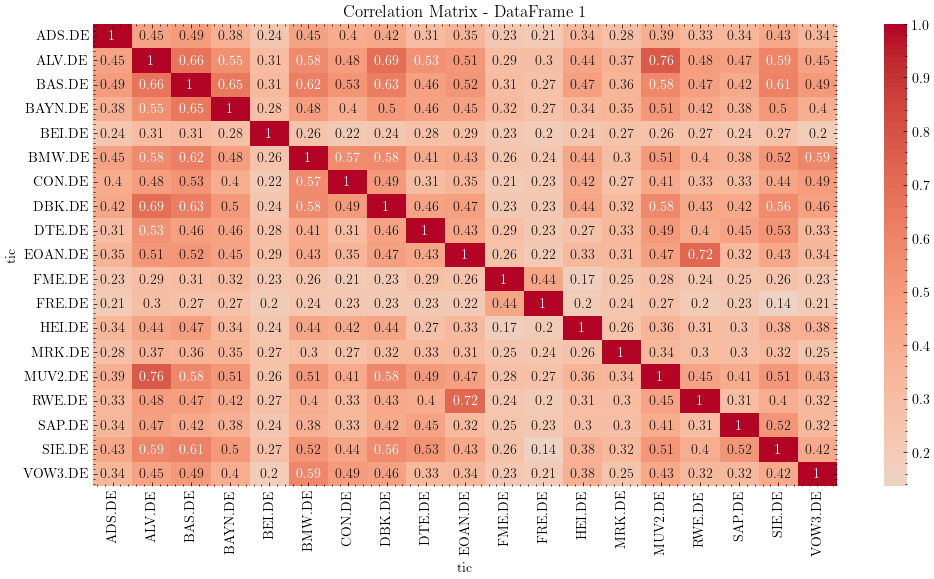

In [199]:
pv = d.pivot(values='log_return',columns='tic',index='date')
pv2 = train_data.pivot(values='log_return',columns='tic',index='date')
train_correlation = pv.corr()
train_correlation2 = pv2.corr()

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_correlation, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix - DataFrame 1")
    plt.show()
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_correlation2, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix - DataFrame 1")
    plt.show()

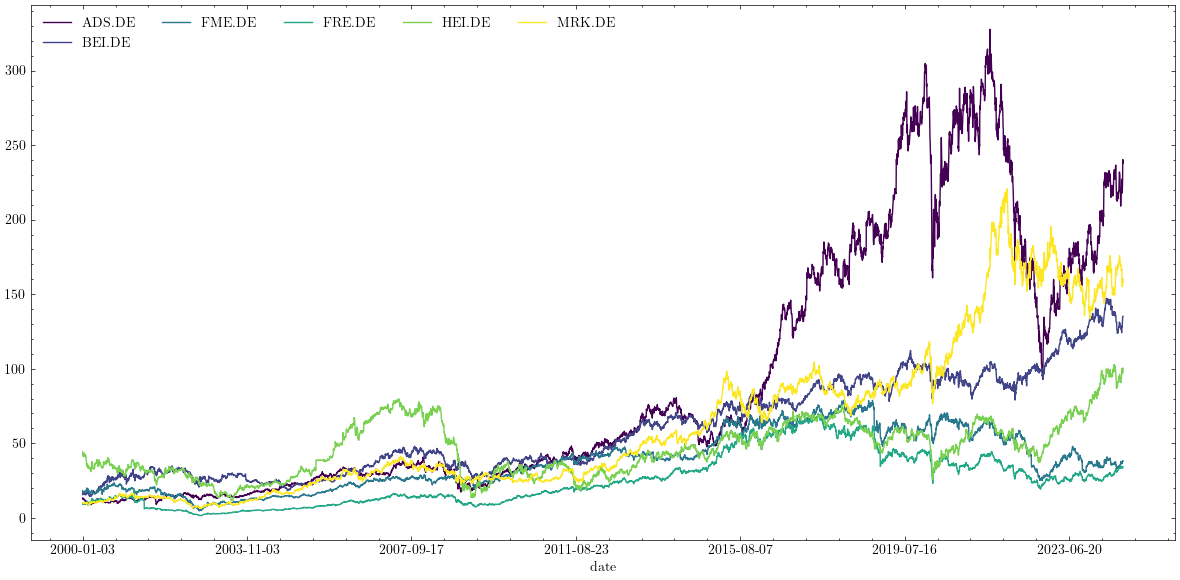

In [202]:
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = processed_dax.pivot(values='close',columns='tic',index='date')
    pv = pv[cleaned_correlation_matrix.columns]
    pv.plot(figsize=(12,6),colormap='viridis')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 

    

In [207]:
df = processed_dax[processed_dax.tic.isin(cleaned_correlation_matrix)]
train_data = data_split(df, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(df, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 6, State Space: 31


In [222]:
iterations = 500_000
result_ddpg =train_model(train_data,train_data,transaction_fee=0.001,load=True,features=["close","log_return"],iterations=iterations,model_name='ddpg',tag='daxsubset_return')
result_ppo = train_model(train_data,train_data,transaction_fee=0.001,load=True,features=["close","log_return"],model_name='ppo',iterations=iterations,tag='dax_subset_return')
result_sac = train_model(train_data,train_data,transaction_fee=0.001,load=True,features=["close","log_return"],model_name='sac',iterations=iterations,tag='dax_subset_return')
result_td3 = train_model(train_data,train_data,transaction_fee=0.001,load=True,features=["close","log_return"],model_name='td3',iterations=iterations,tag='dax_subset_return')

Episode:1
Initial portfolio value:50000
Final portfolio value: 1148916.625
Final accumulative portfolio value: 22.9783325
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 3233097.75
Final accumulative portfolio value: 64.661955
hit end!


In [214]:
stock_dimension = len(train_data.tic.unique())

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    train_data,
    initial_amount=1000000,
    comission_fee_pct=0.0001,
    time_window=5,
    features = ["close", "high", "low"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Episode:1
Initial portfolio value:1000000
Final portfolio value: 9024655.0
Final accumulative portfolio value: 9.024655


In [210]:
covs= mvo_data(df,INDICATORS,TEST_START_DATE,TEST_END_DATE)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0,rf=0)
min_variance_portfolio = mvo(covs,pct=0)

begin_total_asset:50000
end_total_asset:62941.78355991524
Sharpe:  0.9075503467627521
Test Finished!
episode_return 1.2588356711983049
begin_total_asset:50000
end_total_asset:68925.99694883417
Sharpe:  1.4342702858002014
Test Finished!
episode_return 1.3785199389766836


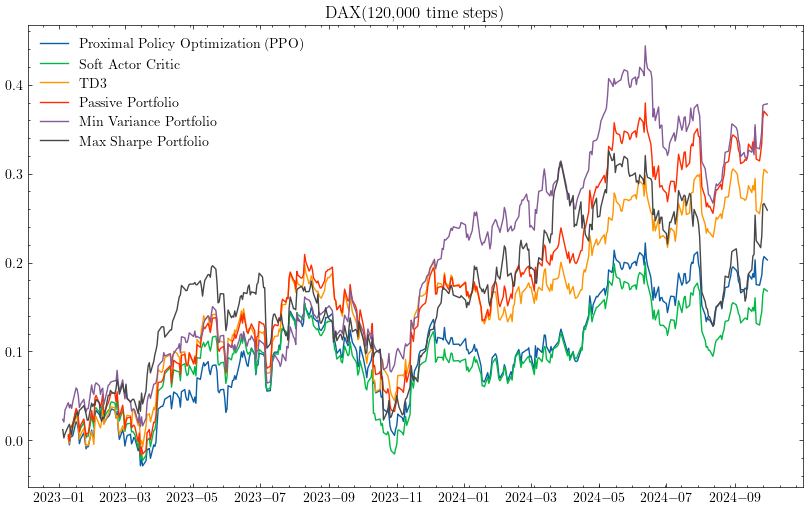

In [213]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod()-1,label = 'Passive Portfolio')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [224]:
result_ppo['test'][0]

date  daily_return       account  \
0    2000-01-07      0.000000  50000.000000   
1    2000-01-10      0.013945  50697.269531   
2    2000-01-11     -0.004697  50459.125000   
3    2000-01-12     -0.001319  50392.578125   
4    2000-01-13     -0.009021  49937.992188   
...         ...           ...           ...   
5872 2022-12-22     -0.008680  96118.976562   
5873 2022-12-23      0.009001  96984.140625   
5874 2022-12-27      0.000451  97027.921875   
5875 2022-12-28     -0.002466  96788.664062   
5876 2022-12-29      0.013128  98059.289062   

                                                weights  
0                   [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
1     [0.091785446, 0.09317495, 0.093169294, 0.09425...  
2     [0.09158503, 0.078705564, 0.20010605, 0.202794...  
3     [0.18671338, 0.28283852, 0.10384598, 0.1055820...  
4     [0.10929866, 0.28823265, 0.1115467, 0.11513214...  
...                                                 ...  
5872  [0.13777201, 0.26089656, 0.09577304, 0.1337193...  
5873  [0.13148114, 0.1322165, 0.14701033, 0.14640062...  
5874  [0.22679457, 0.2018083, 0.0897223, 0.18384942,...  
5875  [0.0996011, 0.2695438, 0.09890491, 0.09936634,...  
5876  [0.17789255, 0.22594379, 0.08212456, 0.2265229...  

[5877 rows x 4 columns]

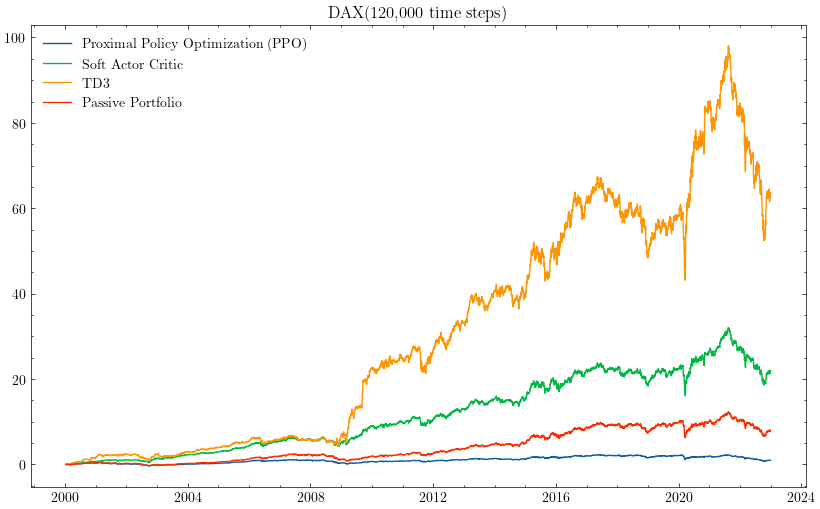

In [223]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod()-1,label = 'Passive Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

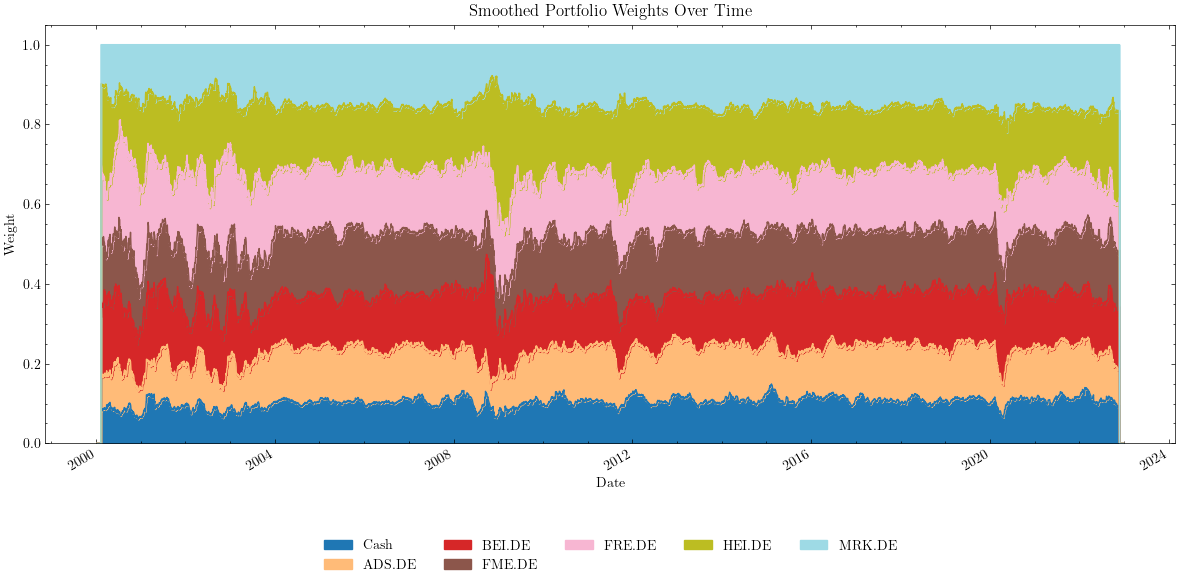

Max Drawdown: -0.29302880596136527
Sharpe Ratio: 2.1107948527410585


In [236]:
import matplotlib.pyplot as plt

# Plot smoothed weights
with plt.style.context('science', 'ieee'):
    fig, ax = plt.subplots(figsize=(12, 6))
    # Apply a rolling average to smooth the data
    window_size =  50 # You can adjust the window size for more or less smoothing
    smoothed_weights = weights.iloc[:, :-1].rolling(window=window_size, center=True).mean()
    smoothed_weights['date'] = weights['date']  # Re-attach the date column
    # Plot smoothed data
    smoothed_weights.iloc[:, :].plot(
        x='date', kind='area', stacked=True, colormap="tab20", ax=ax
    )
    
    # Add legend and labels
    ax.legend(ncol=5, bbox_to_anchor=(0.5, -0.2), loc='upper center', frameon=False)
    ax.set_title("Smoothed Portfolio Weights Over Time")
    ax.set_ylabel("Weight")
    ax.set_xlabel("Date")
    
    plt.tight_layout()
    plt.show()

# Print metrics for context
print('Max Drawdown:', qs.stats.max_drawdown(result_ddpg['test'][0].account))
print('Sharpe Ratio:', qs.stats.sharpe(result_ddpg['test'][0].daily_return))
